<a href="https://colab.research.google.com/github/jmestanza/time_stretching/blob/master/ahhh_con_correlate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%cd /content
from IPython.display import clear_output

#imports
#!pip install librosa
!pip install webrtcvad
import webrtcvad
!pip install --upgrade librosa
import librosa 
import scipy
import numpy as np
from IPython.display import Audio
import matplotlib.pyplot as plt
from math import ceil 
import matplotlib.patches as mpatches

#local modules
!wget https://raw.githubusercontent.com/jmestanza/time_stretching/master/code/detect_pitch_fixed.py
!wget https://raw.githubusercontent.com/jmestanza/time_stretching/master/code/modified_psola_op.py
!wget https://raw.githubusercontent.com/jmestanza/time_stretching/master/code/vad.py
!wget https://raw.githubusercontent.com/jmestanza/time_stretching/master/code/utils.py
#audios
#!wget "https://raw.githubusercontent.com/vicaub/Pitch-Estimation-and-Voicing-Detection/master/data/fda_ue/rl047.wav"
#!wget "https://raw.githubusercontent.com/jmestanza/time_stretching/master/code/input/harry_potter_es.wav"
#!wget "https://raw.githubusercontent.com/jmestanza/time_stretching/master/code/input/hunger_games_en.wav"
#!wget "https://raw.githubusercontent.com/jmestanza/time_stretching/master/code/input/shh.wav"
!wget "https://raw.githubusercontent.com/jmestanza/time_stretching/master/code/input/ahh_without_silences_8k_norm.wav"
#!wget "https://raw.githubusercontent.com/sannawag/TD-PSOLA/master/female_scale.wav"

clear_output()

In [0]:
from modified_psola_op import modified_psola
from detect_pitch_fixed import get_fundamental_frequency
from vad import float2pcm, pcm2float, frame_generator, join_vad_frames, get_vad_frames
from vad import Frame
from scipy import signal
from utils import *

clear_output()

## Prueba con un audio basico

In [0]:
def get_f0s(audio, fs):
    pitches, magnitudes = librosa.core.piptrack(y=audio, sr=fs, fmin=75, fmax=500)
    def detect_pitch(y, sr, t):
        index = magnitudes[:, t].argmax()
        pitch = pitches[index, t]
        return pitch

    print(len(pitches))
    # parece haber siempre 1025:
    indices = []
    for i in range(len(pitches)):
        idx = int(i*(len(pitches)/len(audio)))
        try:
            p = detect_pitch(pitch_arr[i],fs,i)
            if p != 0:
                all_pitches.append(int(fs/p))
                indices.append(idx)
        except:
            pass
        #     all_pitches.append(0)

    return indices, all_pitches

def process_error(e, K, L, fs,p_pk,p_s,speed,is_voiced,regions, show_demo_ = False):
    # p_pk = percent_peak
    # p_s = percent_pitch
    #--------------------------------------------------------------  
    # Esto de aca se puede editar #
    #------------------------------  

    get_p = "pitch_cte" # manera asignar ventanas
    m = "2" # modo de asignar los t_ 
    unv_samples = int(20e-3 * fs) #360
    window_type = "hanning" # ventana con la que hago la correlacion

    #-------------------------------------------
    config_d = {}
    config_d["height"] = 0
    config_d["distance"] = 40
    config_d["prominence"] = None
    config_d["width"] = None
    config_d["threshold"] = None
    
    f0_idx,f0 = get_fundamental_frequency(e,is_voiced, K, L, fs, config_d, w_type = window_type , show_demo= False)
    #f0_idx, f0 = get_f0s(e,fs)
        
    if show_demo_:
        plot_histogram(f0)
        show_demo_ = False
    
    e_, pz, uz = modified_psola(e, f0_idx, f0,p_pk, p_s, speed,is_voiced,regions,get_p,m, unv_samples)
    return e_, f0_idx, f0 , pz, uz


def speed_up(audio_path, speed, sample_rate, K,L, error_with_noise= False, lpc_entero = True):
    
    # paper https://pdfs.semanticscholar.org/7e00/c103c0197a05f9d20511ef03fd8bb0ba81a5.pdf
    # M0 = K,  20 ms
    
    
    #--------------------------------------------------------------  
    # Esto de aca se puede editar #
    #------------------------------  
    std_ = 1e-2
    duration = 1 # empiezo desde 0 y recorto el audio hasta duration segundos
    peak_percent = 0.16
    percent_pitch = 1
    
    #-------------------------------------------------------------------

    audio_f, audio_i = get_float_and_int_audio(audio_path,fs, cut_audio = duration) # audio_i lo necesita el VAD
    if error_with_noise:
        audio_f = get_noise_for_lpc(audio_f, std=std_) # contamino el audio con ruido
    else:
        audio_noised = get_noise_for_lpc(audio_f, std=std_) 
    # Relacion de compromiso, picos grandes o error grande en gral , se ve en el error 

    print("periodicidad minima que se puede estimar",fs/K, "Hz")

    speech, not_speech, is_voiced, frame_len = vad_config(audio_i, fs)

    regions = separate_regions(is_voiced)

    if lpc_entero:
        regions_lpc =  [[0,regions[-1][1]]]
    else:
        regions_lpc = regions.copy()
    
    if error_with_noise:
        error, lpc_coeffs = lpc_filtering(regions_lpc, audio_f, audio_f, coef_number=12)
    else:
        error, lpc_coeffs = lpc_filtering(regions_lpc, audio_f, audio_noised, coef_number=12) 
        # en este no contamino con ruido, tan solo saco los coef lpc con el ruido


    process_output = process_error(error, K, L, fs,peak_percent,percent_pitch,speed,is_voiced,regions)
    psola_error, f0_idx, f0, pitch_zones, unvoiced_zones =  process_output

    voiced_filt = lpc_defiltering(regions_lpc,speed,lpc_coeffs,psola_error)

    is_voiced = np.array(is_voiced)
    is_voiced = is_voiced.astype(np.int16)

    return voiced_filt, psola_error, error, audio_f, is_voiced, pitch_zones, unvoiced_zones, f0, regions

## Pruebas con otros audios

In [9]:
fs = 8000
audio = "/content/ahh_without_silences_8k_norm.wav"
Audio(data=audio, rate=fs)

periodicidad minima que se puede estimar 50.0 Hz


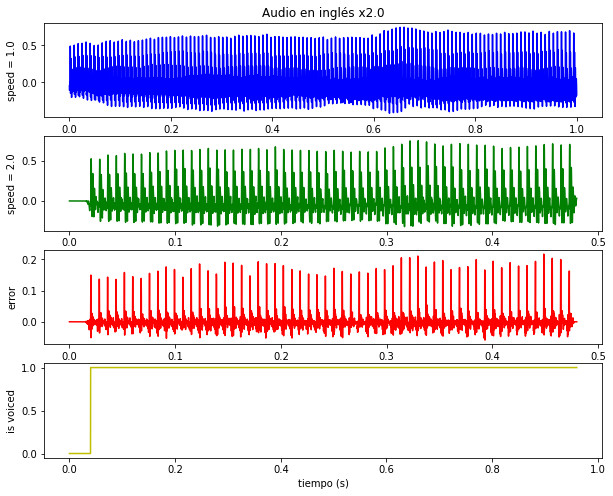

In [20]:
speed = 2.0
#K = int(20e-3 * fs) # esto no se mueve, 50Hz como minimo
#L = int(10e-3 * fs) # 
K = int(20e-3 * fs) # esto no se mueve, 50Hz como minimo
L = int(10e-3 * fs) # 

speed_up_output = speed_up(audio, speed, fs, K,L)
audio_final, psola_err, err, audio_original, is_voice, pz, uz, f0, regions = speed_up_output 

plot_four_signals(audio_original,audio_final,psola_err,is_voice,fs,speed, figsize_=(10,8))
#recordar que f0 es del error
Audio(data=audio_final, rate=fs)

In [0]:
audio_norm =librosa.util.normalize(audio_original[20:1600])
error_norm = librosa.util.normalize(err[20:1600])
plt.plot(audio_norm)
plt.plot(error_norm)
plt.title("Señal error y señal de voz normalizadas")
plt.legend(["Señal de voz","Señal error LPC"])
plt.xlabel("samples")

In [0]:
config_d = {}
config_d["height"] = 0
config_d["distance"] = 150
config_d["prominence"] = None
config_d["width"] = 20
config_d["threshold"] = None
K = int(20e-3 * fs) # esto no se mueve, 50Hz como minimo
L = int(10e-3 * fs) # 

In [0]:
print(K+L)
print(L)

In [0]:
acorr_audio = np.convolve(audio_norm[:L],audio_norm[:L+K])
acorr_error = np.convolve(error_norm[:L],error_norm[:L+K])
plt.plot(acorr_audio[len(acorr_audio)//2:])
plt.plot(acorr_error[len(acorr_error)//2:])
plt.legend(["autoconvol","autoconvol"])

In [0]:
orig = audio_original[20:1600]
error_orig = err[20:1600]
acorr_audio = np.correlate(orig[:L],orig[:L+K],"full")
acorr_error = np.correlate(error_orig[:L],error_orig[:L+K],"full")
plt.plot(librosa.util.normalize(acorr_audio[len(acorr_audio)//2:]))

plt.plot(librosa.util.normalize(acorr_error[len(acorr_error)//2:]))

plt.title("Plot de las autocorrelaciones normalizadas")
plt.legend(["aucorr modif de señal","autocorr modif de error"])
plt.xlabel("samples")

In [0]:
plt.plot(acorr_audio[len(acorr_audio)//2:])

In [0]:
import matplotlib.pyplot as plt

print(len(f0))
n, bins, patches = plt.hist(x=f0, bins='auto', color='#0504aa', alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Estimación de frecuencia en muestra$\hat{f_0}$')
plt.ylabel('Ocurrencias')
plt.title('Histograma de frecuencias')

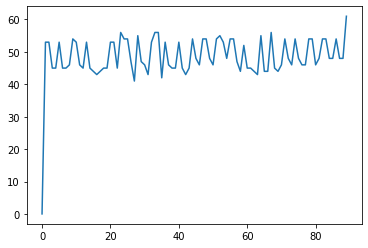

In [21]:
plt.plot(f0)